In [15]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns  
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

# Scikit-Learn modules for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [16]:
df = pd.read_csv('data/games.csv')

In [17]:
# Check the structure of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB
None


In [18]:
# Dataset Shape and Data Types
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes.value_counts())

# Summary of numerical columns
df.describe()

# Count unique values in categorical columns
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")

Dataset Shape: (20058, 16)

Data Types:
object     9
int64      4
float64    2
bool       1
Name: count, dtype: int64
id: 19113 unique values
victory_status: 4 unique values
winner: 3 unique values
increment_code: 400 unique values
white_id: 9438 unique values
black_id: 9331 unique values
moves: 18920 unique values
opening_eco: 365 unique values
opening_name: 1477 unique values


In [19]:
# What are the victory statuses?
victory_counts = df['victory_status'].value_counts()
print("\nVictory Status Counts:")
print(victory_counts)


Victory Status Counts:
victory_status
resign       11147
mate          6325
outoftime     1680
draw           906
Name: count, dtype: int64


In [20]:
# Check for missing values
print(df.isnull().sum())

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64


In [21]:
# Preview the dataset
print(df.head())

         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_e

In [22]:
# Drop columns that are not useful for modeling
df_processed = df.drop(columns=['id', 'rated', 'created_at', 'last_move_at', 'white_id', 'black_id', 'moves', 'opening_name', 'victory_status'])

In [23]:
# The 'winner' column has 3 outcomes. Let's map them to numbers.
df_processed['winner'] = df['winner'].map({'white': 1, 'black': -1, 'draw': 0})

In [24]:
df_processed['rating_difference'] = df_processed['white_rating'] - df_processed['black_rating']

# Now that we have the difference, the individual ratings are less important.
# We can drop them to avoid multicollinearity.
df_processed = df_processed.drop(columns=['white_rating', 'black_rating'])

In [25]:
# Let's see the most common opening codes
print(df_processed['opening_eco'].value_counts().head(10))

opening_eco
A00    1007
C00     844
D00     739
B01     716
C41     691
C20     675
A40     618
B00     611
B20     567
C50     538
Name: count, dtype: int64


In [26]:
# Group all openings that appear less than, say, 10 times into an 'Other' category
opening_counts = df_processed['opening_eco'].value_counts()
rare_openings = opening_counts[opening_counts < 10].index
df_processed['opening_eco'] = df_processed['opening_eco'].replace(rare_openings, 'Other')

print(f"\nNew number of unique opening ECOs: {df_processed['opening_eco'].nunique()}")


New number of unique opening ECOs: 188


In [27]:
# Create the features (X) and target (y)
X = df_processed.drop('winner', axis=1)
y = df_processed['winner']

# Convert categorical variables into dummy/indicator variables
X = pd.get_dummies(X, columns=['opening_eco', 'increment_code'], drop_first=True)

In [28]:
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (16046, 589)
Testing set shape: (4012, 589)


In [29]:
# Baseline: Predict winner based only on rating difference
# 1 if white has higher rating, -1 if black has higher rating
baseline_preds = np.sign(X_test['rating_difference'])

# Note: This simple baseline can't predict draws (0), so we'll replace 0s with 1 (predicting a white win).
baseline_preds[baseline_preds == 0] = 1

# Evaluate the baseline
print("Baseline Accuracy:", accuracy_score(y_test, baseline_preds))

Baseline Accuracy: 0.6186440677966102



Logistic Regression Performance:
              precision    recall  f1-score   support

          -1       0.59      0.59      0.59      1822
           0       0.21      0.02      0.03       190
           1       0.62      0.68      0.65      2000

    accuracy                           0.61      4012
   macro avg       0.48      0.43      0.42      4012
weighted avg       0.59      0.61      0.59      4012



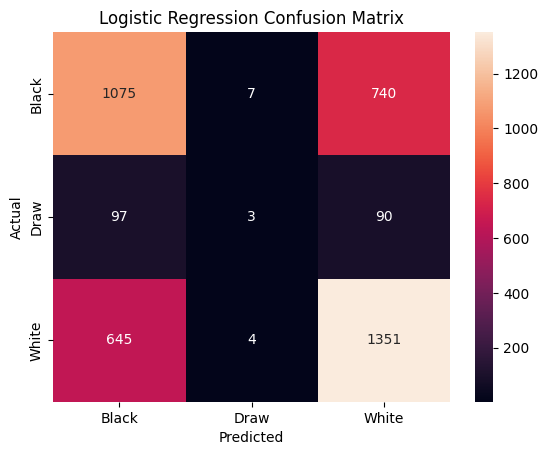

In [ ]:
# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000) # max_iter might be needed for convergence
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log = log_reg.predict(X_test)

# Evaluate the model
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred_log))

# Visualize the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Black', 'Draw', 'White'], yticklabels=['Black', 'Draw', 'White'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


Random Forest Performance:
              precision    recall  f1-score   support

          -1       0.63      0.64      0.63      1822
           0       0.56      0.13      0.21       190
           1       0.65      0.70      0.67      2000

    accuracy                           0.64      4012
   macro avg       0.61      0.49      0.50      4012
weighted avg       0.64      0.64      0.63      4012



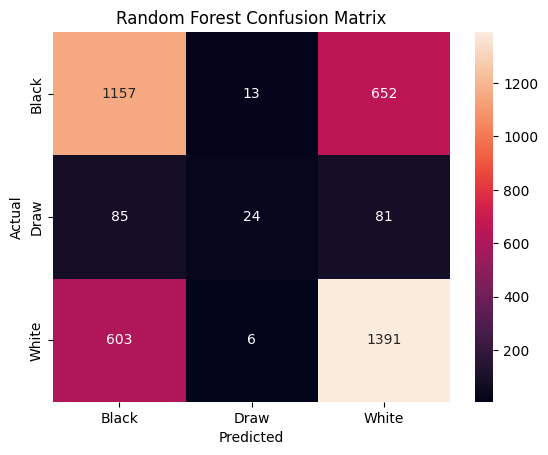

In [32]:
# Initialize and train the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=3, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))

# Visualize the Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=['Black', 'Draw', 'White'], yticklabels=['Black', 'Draw', 'White'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest Confusion Matrix')
plt.show()